In [122]:
import os
from pyrosm import OSM
import osmnx as ox
import geopandas as gpd
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import folium
from folium import plugins
import branca.colormap as cm
import json
#project specific packages
import services.network_bands as network_bands
import services.batch_csv as batch_csv
import services.census_merge as census_merge
import services.pandas_aux as pdaux

In [123]:
#set base directory for data file paths.
base_dir = os.getcwd()
# create network graph and edges.
base_road_path = f'{base_dir}\\testEnvironment\\Data\\belfast.osm.pbf'
G, nodes, edges = network_bands.load_osm_network(file_path=base_road_path, network_type='driving', graph_type='networkx')

In [124]:
#Start locations
start_locations = pd.read_csv(f'{base_dir}\\testEnvironment\\Data\\libraries_belfast_2024.csv')
print(start_locations.columns)
#Ensure data is converted to a dataframe
start_locations_gdf = network_bands.csv_to_gdf(start_locations, 'X COORDINATE', 'Y COORDINATE', 29902, 4326)

Index(['Static Library Name', 'Number', 'Street', 'Town', 'Postcode', 'Tel No',
       'X COORDINATE', 'Y COORDINATE'],
      dtype='object')


1 of 18
2 of 18
3 of 18
4 of 18
5 of 18
6 of 18
7 of 18
8 of 18
9 of 18
10 of 18
11 of 18
12 of 18
13 of 18
14 of 18
15 of 18
16 of 18
17 of 18
18 of 18
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 1 of 18: Ardoyne Library. 
Average time for each completion is 3.28 seconds.
Total predicted time to complete all tasks is 59.01 seconds.
3.2781996726989746
The process has been running for 3.28 seconds.
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 2 of 18: Ballyhackamore Library. 
Average time for each completion is 4.01 seconds.
Total predicted time to complete all tasks is 72.21 seconds.
4.7453203201293945
The process has been running for 8.02 seconds.
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 3 of 18: Belfast Central Library. 
Average time for each completion is 4.97 seconds.
Total predicted time to complete all tasks is 89.52 seconds.
6.897279739379883
The process has been r

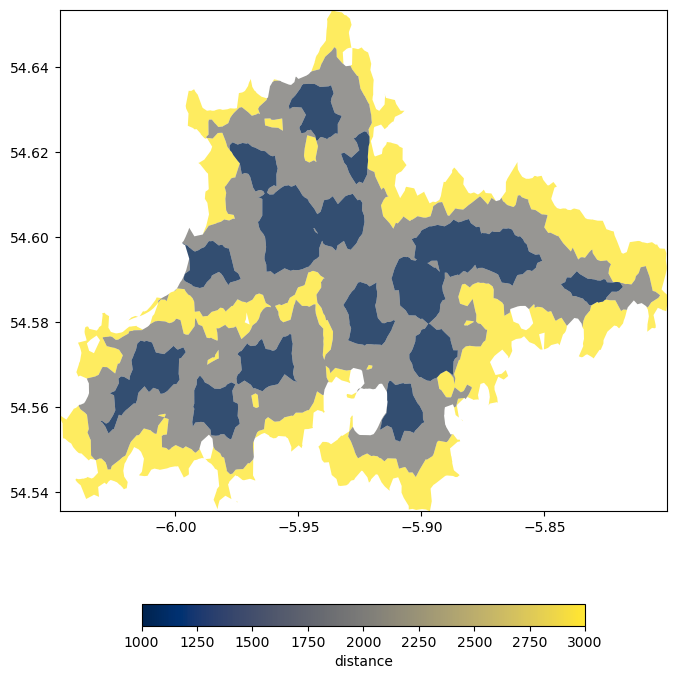

A map showing network contours has been created.


In [125]:
#Network graph creation.
#Create the network areas and contours - Considering making this into a Class with basic GUI, but for now fine as this.
start_locations_nearest_node = network_bands.nearest_node_and_name(G, start_locations=start_locations_gdf,  
                                                                   location_name = 'Static Library Name')

#Create service areas for each distance. Remember, these overlap, good for counting checking how close 
#input custom distances as a list.
search_distances = [1000,2000,3000]
#Create individual network areas around start locations. alpha area of 500 quite good for Belfast
network_areas = network_bands.network_areas(nearest_node_dict=start_locations_nearest_node, graph=G, 
                                                    search_distances=search_distances, alpha_value=500, weight = 'length', progress=True)
#Create network area contours by dissolving and differencing polygons based on distance.
network_service_areas = network_bands.network_service_areas(network_areas, dissolve_cat='distance',aggfunc='first', show_graph=True)

In [126]:
#Load in data zones from 2021 census
#Ensure evrything's in 4326 for network analysis, probably can change it back to tm65.
data_zones = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\DZ2021.shp')
data_zones.to_crs(4326, inplace=True)
#extract only belfast datazones
belfast_zones = data_zones[data_zones['LGD2014_nm'] == 'Belfast']

#Load in house data 
pointer = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\pointer_randomised.shp')
pointer['uuid'] = pointer.apply(lambda i: uuid.uuid4(), axis=1)
pointer.to_crs(4326, inplace=True)
belfast_zones.to_crs(pointer.crs, inplace=True)

c:\Users\hular\anaconda3\envs\netgeo_env\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [127]:
# Perform a spatial join of pointer households and datazones in Belfast to calculate households in each datazone
joined_gdf = gpd.sjoin(pointer, belfast_zones, how='left', predicate='intersects' )
#number of points found within each datazone
datazone_pointer_count = joined_gdf.groupby('DZ2021_cd')['DZ2021_cd'].count().rename('actual_households').reset_index()
belfast_zones = pd.merge(belfast_zones, datazone_pointer_count, how = 'left')

In [128]:
#Load the Census data, file_paths in file_paths.
file_paths = [
    '/testEnvironment/Data/census_data/ni-2021-usual-residents.csv',
    '/testEnvironment/Data/census_data/ni-2021-households.csv',
    '/testEnvironment/Data/census_data/ni-2021-employment-deprivation.csv'
]
#extract each one from dataframe
loaded_csv = batch_csv.batch_csv_read(file_paths)

#check data is loaded loaded
print(loaded_csv.keys())

#force rename to maintain consistency of important join value column.
loaded_csv['ni-2021-employment-deprivation'].rename(columns={'Census 2021 Data Zone Code':'Geography code',
                                                             'Count':'employment_deprivation_count'}, inplace=True)

#OSNI data has irregular capitalisation, avoids this bug by forcing lower case. Some are 'Geography Code', 'geography Code' etc.
# Need to incorporate this properly into function
for key, df in loaded_csv.items():
    df.columns = df.columns.str.lower()
    
joined_census_data = census_merge.join_census_csv(loaded_csv, 'geography code',  drop=True,join_type='left')
#dropping some extraneous columns as they are not needed and clutter the dataset
joined_census_data.drop(columns=['household deprivation (employment) code','household deprivation (employment) label'], inplace=True)

dict_keys(['ni-2021-usual-residents', 'ni-2021-households', 'ni-2021-employment-deprivation'])
The following columns were duplicates from the right join and were dropped: [['geography', 'access census area explorer'], []]


In [129]:
# Merge the data zones with the 
belfast_zones_census = pd.merge(belfast_zones, joined_census_data, left_on='DZ2021_cd', right_on='geography code', how='left', suffixes=('_left', '_right'))

# Drop the duplicate columns from the merged dataframe
census_merge.drop_dupe_cols(belfast_zones_census, ('_left', '_right'))

In [130]:
#Calculate CENSUS METRICS PER HOUSE in pointer data
#join the census data loaded 
#Need to force these to numeric. Ensure coerce for any nulls
belfast_zones_census['all households'] = pd.to_numeric(belfast_zones_census['all households'], errors = 'coerce')
belfast_zones_census['all usual residents'] = pd.to_numeric(belfast_zones_census['all usual residents'], errors = 'coerce')
## Calculate your metrics. Average resident per house etc.
# actual household data has been extracted by spatial join of the randomised poitner dataset. 
#average residents per household
belfast_zones_census['avg_resi_house'] = (belfast_zones_census['all usual residents'] / belfast_zones_census['actual_households'])
#actual residents based off pointer
belfast_zones_census['actual_total_residents'] = (belfast_zones_census['avg_resi_house'] * belfast_zones_census['actual_households'])
#average number of employment deprived people per household. - Super relevant for this analysis.
belfast_zones_census['avg_emp_dep_per_house'] = (belfast_zones_census['employment_deprivation_count'] / belfast_zones_census['actual_households'])*belfast_zones_census['avg_resi_house']
#average number of employmenet deprived people per resident.
belfast_zones_census['avg_emp_dep_per_capita'] = (belfast_zones_census['employment_deprivation_count'] / belfast_zones_census['all usual residents'])*belfast_zones_census['avg_resi_house']

#Force to gdf, currently will be a panda series
belfast_zones_census = gpd.GeoDataFrame(belfast_zones_census)


In [131]:
# Spatial join to find which network contour each household falls into
households_with_contour = gpd.sjoin(pointer, network_service_areas, how="left", predicate="within")
households_with_contour = households_with_contour.drop(columns='index_right').reset_index(drop=True)

# spatial to join data zone data to each household
households_with_zones = gpd.sjoin(households_with_contour, belfast_zones_census, how="left", predicate="within").drop(columns='index_right').reset_index(drop=True)

# Group by census zone and distance and then count. Unstacks the distance columns to create separate columns for each distance.
household_counts = households_with_zones.groupby(['DZ2021_cd', 'distance']).size().unstack(fill_value=0)

#join this back to the belfast_census_zones to add the counts as new columns
belfast_census_zones = belfast_zones_census.merge(household_counts, on='DZ2021_cd', how='left')

#forces column names to string, as distance will be integer.
belfast_census_zones.columns = belfast_census_zones.columns.astype(str)
#replace NaNs with 0s
pdaux.fill_na_with_zero(belfast_census_zones, ['1000.0','2000.0','3000.0'])


DZ2021_cd   DZ2021_nm SDZ2021_cd SDZ2021_nm LGD2014_nm  \
0    N20000711  Oldpark_A1  N21000161  Oldpark_A    Belfast   
1    N20000712  Oldpark_A2  N21000161  Oldpark_A    Belfast   
2    N20000713  Oldpark_A3  N21000161  Oldpark_A    Belfast   
3    N20000714  Oldpark_B1  N21000162  Oldpark_B    Belfast   
4    N20000715  Oldpark_D1  N21000164  Oldpark_D    Belfast   
..         ...         ...        ...        ...        ...   
730  N20001441    Court_X3  N21000335    Court_X    Belfast   
731  N20001442    Court_T3  N21000332    Court_T    Belfast   
732  N20001443    Court_X4  N21000335    Court_X    Belfast   
733  N20001444    Court_W4  N21000334    Court_W    Belfast   
734  N20001445    Court_X5  N21000335    Court_X    Belfast   

                                              geometry  actual_households  \
0    POLYGON ((-5.98558 54.65897, -5.98554 54.65895...                252   
1    POLYGON ((-5.98748 54.62241, -5.98748 54.62241...                174   
2    POLYGON ((-5.97900 54.62839, -5.97960 54.62877...                214   
3    POLYGON ((-5.96441 54.62989, -5.96486 54.63013...                105   
4    POLYGON ((-5.98875 54.62846, -5.98886 54.62841...                227   
..                                                 ...                ...   
730  POLYGON ((-5.96144 54.59517, -5.96158 54.59525...                239   
731  POLYGON ((-5.96576 54.59507, -5.96579 54.59508...                191   
732  POLYGON ((-5.95899 54.59542, -5.95904 54.59563...                193   
733  POLYGON ((-5.94299 54.59546, -5.94248 54.59537...                270   
734  POLYGON ((-5.94938 54.59222, -5.94938 54.59189...                181   

      geography geography code  all usual residents  ... all households  \
0    Oldpark_A1      N20000711                764.0  ...          247.0   
1    Oldpark_A2      N20000712                475.0  ...          161.0   
2    Oldpark_A3      N20000713                584.0  ...          203.0   
3    Oldpark_B1      N20000714                248.0  ...          105.0   
4    Oldpark_D1      N20000715                581.0  ...          221.0   
..          ...            ...                  ...  ...            ...   
730    Court_X3      N20001441                527.0  ...          231.0   
731    Court_T3      N20001442                489.0  ...          187.0   
732    Court_X4      N20001443                366.0  ...          177.0   
733    Court_W4      N20001444                640.0  ...          267.0   
734    Court_X5      N20001445                394.0  ...          174.0   

     census 2021 data zone label employment_deprivation_count  avg_resi_house  \
0                     Oldpark_A1                        201.0        3.031746   
1                     Oldpark_A2                        132.0        2.729885   
2                     Oldpark_A3                        155.0        2.728972   
3                     Oldpark_B1                         74.0        2.361905   
4                     Oldpark_D1                        167.0        2.559471   
..                           ...                          ...             ...   
730                     Court_X3                        184.0        2.205021   
731                     Court_T3                        130.0        2.560209   
732                     Court_X4                        116.0        1.896373   
733                     Court_W4                        170.0        2.370370   
734                     Court_X5                        131.0        2.176796   

     actual_total_residents  avg_emp_dep_per_house  avg_emp_dep_per_capita  \
0                     764.0               2.418178                0.797619   
1                     475.0               2.070947                0.758621   
2                     584.0               1.976592                0.724299   
3                     248.0               1.664580                0.704762   
4                     581.0               1.882959         

In [132]:
#Create a folium map - This part's quite manual.
##ADD PIE CHARTS INSTEAD -0this is tricky
#turn this into a bunch of functions to get this smaller and more refined down the line.
#Numbers will be off due to randomisation of pointer dataset.
belfast_census_data_geojson = json.loads(belfast_census_zones.to_json())
network_service_areas_geojson = json.loads(network_service_areas.to_json())

# Create the Folium map centered around the average coordinates of your geometries, can ignore warning
map_center = belfast_census_zones.geometry.centroid.unary_union.centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=12)

#could turn this network_service_areas_style creation into a larger func
distances = [1000, 2000, 3000] 
colours = ['green', 'orange', 'red']
color_map = cm.LinearColormap(
    colors=colours,
    vmin=min(distances),
    vmax=max(distances),
    caption='Distance to Network Contours'
)
distance_colours = {dist: colour for dist, colour in zip(distances, colours)}
def network_service_areas_style(feature):
    """Apply styles based on the distance attribute."""
    distance = feature['properties']['distance']
    return {
        'color': distance_colours.get(distance, 'gray'),
        'weight': 2,
        'opacity': 0.8,
        'fillColor': distance_colours.get(distance, 'gray'), 
        'fillOpacity': 0.5
    }

#basic styling for the polygons
def basic_poly_styling(feature):
    return {
        'color': 'black',
        'weight':1,
        'fillOpacity': 0.1
    }

#defines the highlight colour
def highlight_function(feature):
    return {
        'color': 'yellow',
        'weight': 2,
        'fillOpacity':0.2
    }
network_service_areas_layer = folium.GeoJson(
    network_service_areas_geojson,
    style_function=network_service_areas_style,
    name = 'contours',
    tooltip=folium.GeoJsonTooltip(
        fields=['distance'],
        aliases=['Distance:'],
        localize = True
    )
)
network_service_areas_layer.add_to(m)
from folium.features import GeoJsonPopup

#census zone layer
data_zone_layer = folium.GeoJson(
    belfast_census_data_geojson,
    name='Houses within 1000m',
    style_function=basic_poly_styling,
    highlight_function=highlight_function,

    popup = GeoJsonPopup(
        fields=['DZ2021_cd', 'DZ2021_nm', 'actual_households', '1000.0', '2000.0', '3000.0'],
        aliases=['Data Zone:', 'Data Zone Name:', 'Households:', 'Households within 1km:', 
                'Households within 2km:', 'Households within 3km:'],
        localize=True,
        labels=True
    )
)
data_zone_layer.add_to(m)

# layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('test.html', cdn_resources='cdn')

m

C:\Users\hular\AppData\Local\Temp\ipykernel_23348\1138155886.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = belfast_census_zones.geometry.centroid.unary_union.centroid


In [133]:
network_service_areas

geometry  distance
0  MULTIPOLYGON (((-5.97463 54.53756, -5.97478 54...      3000
1  MULTIPOLYGON (((-6.03176 54.56744, -6.03124 54...      2000
2  MULTIPOLYGON (((-5.99137 54.56528, -5.99127 54...      1000

In [134]:
print(data['households1000'].describe())


count    735.000000
mean      71.429932
std       96.081611
min        0.000000
25%        0.000000
50%        0.000000
75%      158.500000
max      374.000000
Name: households1000, dtype: float64
